# EQS GB Cross-Validation for Simple sources

Using cross-validation to determine the best damping and depth for the model.

In [1]:
import warnings
import itertools
import numpy as np
import verde as vd
import pandas as pd
import xarray as xr
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import eqs_magnetics as eqs
import synthetics

In [2]:
# Suppress some scikit-learn warning that isn't valid
warnings.filterwarnings("ignore", category=RuntimeWarning)

Set the data coordinates and field direction.

N data: 92046


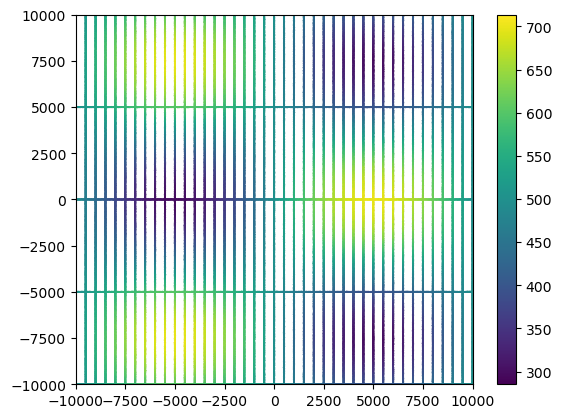

In [3]:
region = [-10e3, 10e3, -10e3, 10e3]
# Inc and dec from the IGRF around Antarctica
field_direction = eqs.angles_to_vector(inclination=84, declination=120, amplitude=1)
#field_direction = eqs.angles_to_vector(inclination=14, declination=122, amplitude=1)

# Generate fake flight lines
easting, northing = [c.ravel() for c in vd.grid_coordinates(region, spacing=(10, 500))]
easting_tie, northing_tie = [c.ravel() for c in vd.grid_coordinates(region, spacing=(5000, 10))]
easting = np.concatenate([easting, easting_tie])
northing = np.concatenate([northing, northing_tie])
upward = vd.synthetic.CheckerBoard(region=region, amplitude=200, w_east=20000, w_north=15000).predict((easting, northing)) + 500
coordinates = (easting, northing, upward)
for i, c in enumerate(coordinates):
    eqs.contaminate(c, standard_deviation=5, random_state=i)

print("N data:", coordinates[0].size)

plt.scatter(*coordinates[:2], c=coordinates[2], s=0.1)
plt.xlim(*region[:2])
plt.ylim(*region[2:])
plt.colorbar()
plt.show()

Create the dipole source model.

In [4]:
source_direction = [70, 60] # [inc, dec]
source_coordinates, dipole_moments = synthetics.simple_synthetic(
    dike1=source_direction,
    dike2=source_direction,
    point1=source_direction,
    point2=source_direction,
    point3=source_direction,
    point4=source_direction,
    regional=source_direction,
)

In [5]:
b_field = eqs.dipole_magnetic(coordinates, source_coordinates, dipole_moments)

In [6]:
tfa = eqs.contaminate(
    eqs.total_field_anomaly(b_field, field_direction), standard_deviation=50, random_state=42,
)
bnorm = eqs.magnetic_field_norm(b_field)

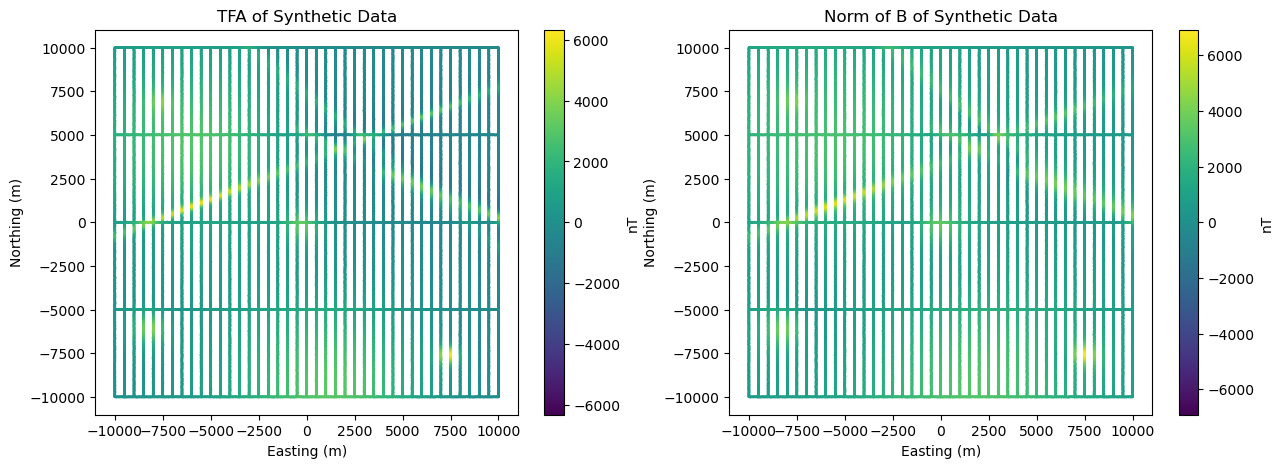

In [7]:
plt.figure(figsize=(15,5))
scale = vd.maxabs(tfa)
#scale = 1000
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa, cmap="viridis", s=0.5, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

scale_bnorm = vd.maxabs(bnorm)
plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=bnorm, cmap="viridis", s=0.5, vmin=-scale_bnorm, vmax=scale_bnorm)
plt.title("Norm of B of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Fit deep sources

Block reduce the data has several advantages:

1. Less data to fit so much faster.
2. The block median reduces the wavelengths in the data, which captures the regional field and leaves the residuals alone.

In [8]:
reducer = vd.BlockReduce(reduction=np.median, spacing=2e3, drop_coords=False)
# Use the filter method to apply the reduction:
coords_blocked, tfa_blocked = reducer.filter(coordinates, data=tfa)

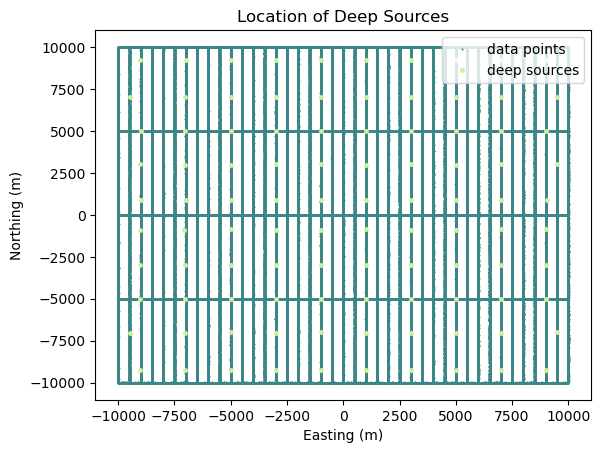

In [9]:
plt.figure()
plt.plot(*coordinates[:2], ".", color="#3B8686", markersize=1, label='data points')
plt.plot(*coords_blocked[:2], ".", color="#CFF09E", markersize=5, label='deep sources')
plt.title("Location of Deep Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.legend()
plt.show()

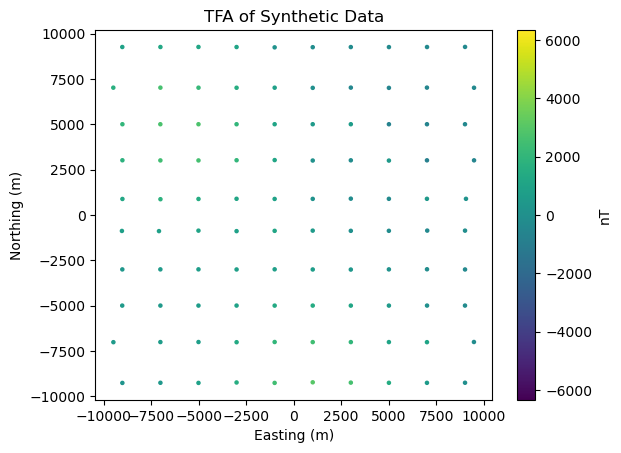

In [10]:
plt.figure()
plt.scatter(*coords_blocked[:2], c=tfa_blocked, cmap="viridis", s=5, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

In [11]:
%%time
eqs_deep = eqs.EquivalentSourcesMagnetic(damping=1e-5)
eqs_deep.fit(coords_blocked, tfa_blocked, field_direction)
print("source height:", eqs_deep.dipole_coordinates_[2][0])

source height: -7770.888309791348
CPU times: user 1.35 s, sys: 401 ms, total: 1.75 s
Wall time: 417 ms


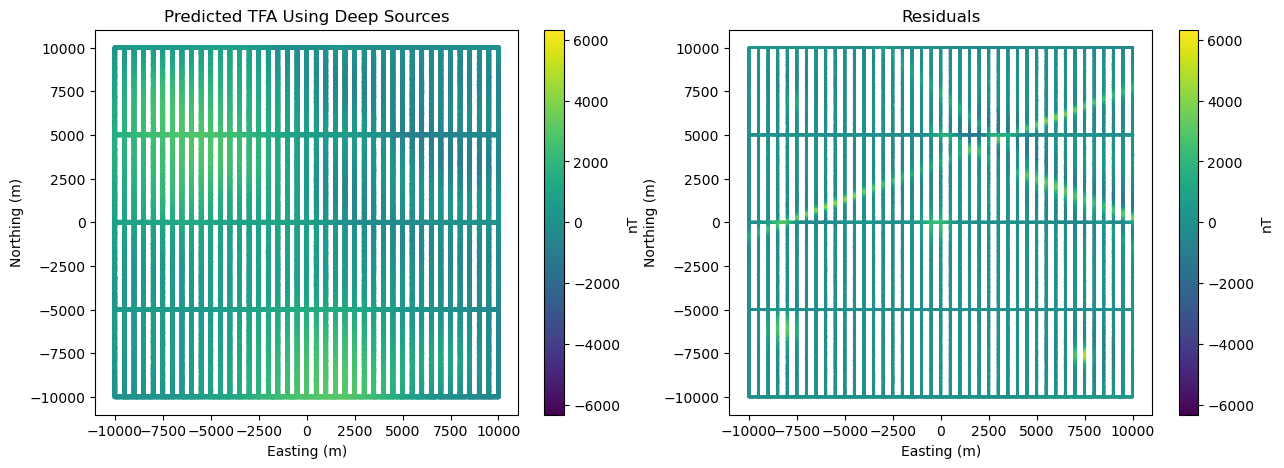

In [12]:
tfa_deep_blocked = eqs.total_field_anomaly(eqs_deep.predict(coords_blocked), field_direction)
tfa_deep = eqs.total_field_anomaly(eqs_deep.predict(coordinates), field_direction)
tfa_residuals = tfa - tfa_deep

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa_deep, cmap="viridis", s=5, vmin=-scale, vmax=scale)
plt.title("Predicted TFA Using Deep Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=tfa_residuals, cmap="viridis", s=1, vmin=-scale, vmax=scale)
plt.title("Residuals")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Fit the deep residuals with gradient-boosted sources

In [13]:
dampings = [1e-2, 1e-1, 1e1, 1e2]
depths = [200, 400, 600, 800]
parameter_sets = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings, depths)
]
print("Number of combinations:", len(parameter_sets))
# print("Combinations:", parameter_sets)

Number of combinations: 16


In [14]:
%%time
kfold = vd.BlockKFold(
    spacing=500,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coordinates[:2])
scores = []
for parameters in parameter_sets:    
    print(parameters)
    eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=100, **parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_shallow.fit(
            [c[train] for c in coordinates], 
            tfa_residuals[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_shallow.predict([c[test] for c in coordinates]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa_residuals[test] - predicted))
    scores.append(np.mean(tmp))
    print(np.mean(tmp))

{'damping': 0.01, 'depth': 200}
55844.51184304543
{'damping': 0.01, 'depth': 400}
32673.150396540797
{'damping': 0.01, 'depth': 600}
19338.814948052437
{'damping': 0.01, 'depth': 800}
17944.269177863993
{'damping': 0.1, 'depth': 200}
55838.253781616455
{'damping': 0.1, 'depth': 400}
32896.870874019354
{'damping': 0.1, 'depth': 600}
19778.63710648021
{'damping': 0.1, 'depth': 800}
18765.41646020724
{'damping': 10.0, 'depth': 200}
55933.400310188204
{'damping': 10.0, 'depth': 400}
35510.47498496207
{'damping': 10.0, 'depth': 600}
22938.536651231014
{'damping': 10.0, 'depth': 800}
22712.74160649862
{'damping': 100.0, 'depth': 200}
56108.97056175481
{'damping': 100.0, 'depth': 400}
37849.78435457798
{'damping': 100.0, 'depth': 600}
26030.165000267112
{'damping': 100.0, 'depth': 800}
26314.579651705768
CPU times: user 3h 54min 21s, sys: 1h 4min 36s, total: 4h 58min 57s
Wall time: 12min 54s


In [15]:
best = np.argmin(scores)
parameter_sets[best]

{'damping': 0.01, 'depth': 800}

In [16]:
%%time
eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=100, **parameter_sets[best])
eqs_shallow.fit(coordinates, tfa_residuals, field_direction)
print("dipole height:", eqs_shallow.dipole_coordinates_[2][0])
print("window size:", eqs_shallow.window_size_)

dipole height: -299.5717779840325
window size: 4669.642453391388
CPU times: user 3min 51s, sys: 1min 3s, total: 4min 55s
Wall time: 11.7 s


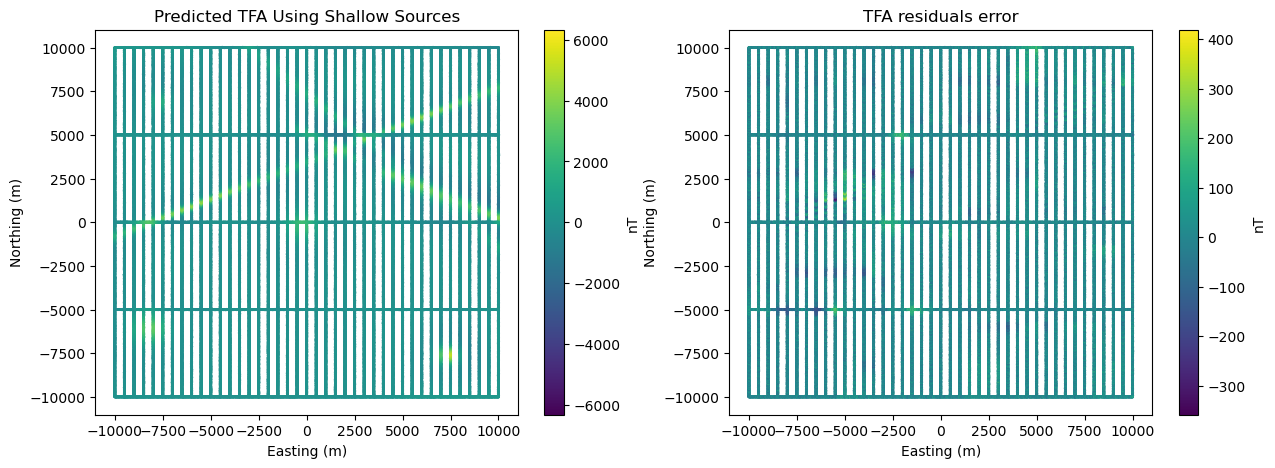

In [17]:
tfa_residuals_prediction = eqs.total_field_anomaly(eqs_shallow.predict(coordinates), field_direction)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa_residuals_prediction, cmap="viridis", s=1, vmin=-scale, vmax=scale)
plt.title("Predicted TFA Using Shallow Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=tfa_residuals - tfa_residuals_prediction, s=1)
plt.title("TFA residuals error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Predict the norm of B

In [18]:
grid_coordinates = vd.grid_coordinates(region, spacing=100, extra_coords=500)
true_tfa = eqs.total_field_anomaly((eqs.dipole_magnetic(grid_coordinates, source_coordinates, dipole_moments)), field_direction)
predicted_tfa = eqs.total_field_anomaly((eqs_deep.predict(grid_coordinates) + eqs_shallow.predict(grid_coordinates)), field_direction)
error_tfa = true_tfa - predicted_tfa

In [19]:
true_norm_of_b = np.sqrt(sum(c**2 for c in eqs.dipole_magnetic(grid_coordinates, source_coordinates, dipole_moments)))
predicted_norm_of_b = np.sqrt(sum(c**2 for c in eqs_deep.predict(grid_coordinates) + eqs_shallow.predict(grid_coordinates)))
error_norm_of_b = true_norm_of_b - predicted_norm_of_b

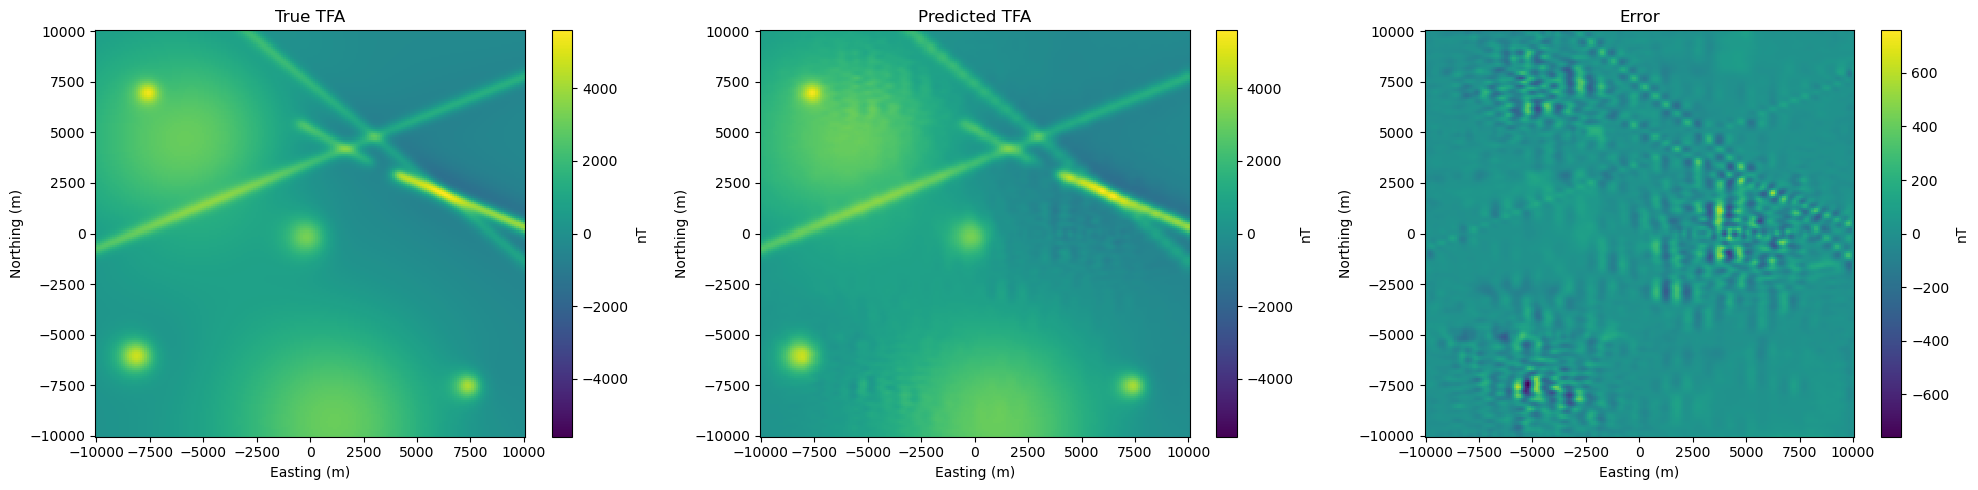

In [20]:
scale_tfa = vd.maxabs(true_tfa)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.pcolormesh(*grid_coordinates[:2], true_tfa, cmap="viridis", vmin=-scale_tfa, vmax=scale_tfa)
plt.title("True TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
plt.pcolormesh(*grid_coordinates[:2], predicted_tfa, cmap="viridis", vmin=-scale_tfa, vmax=scale_tfa)
plt.title("Predicted TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
diff_scale = vd.maxabs(error_tfa)
plt.pcolormesh(*grid_coordinates[:2], error_tfa, cmap="viridis", vmin=-diff_scale, vmax=diff_scale)
plt.title("Error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()

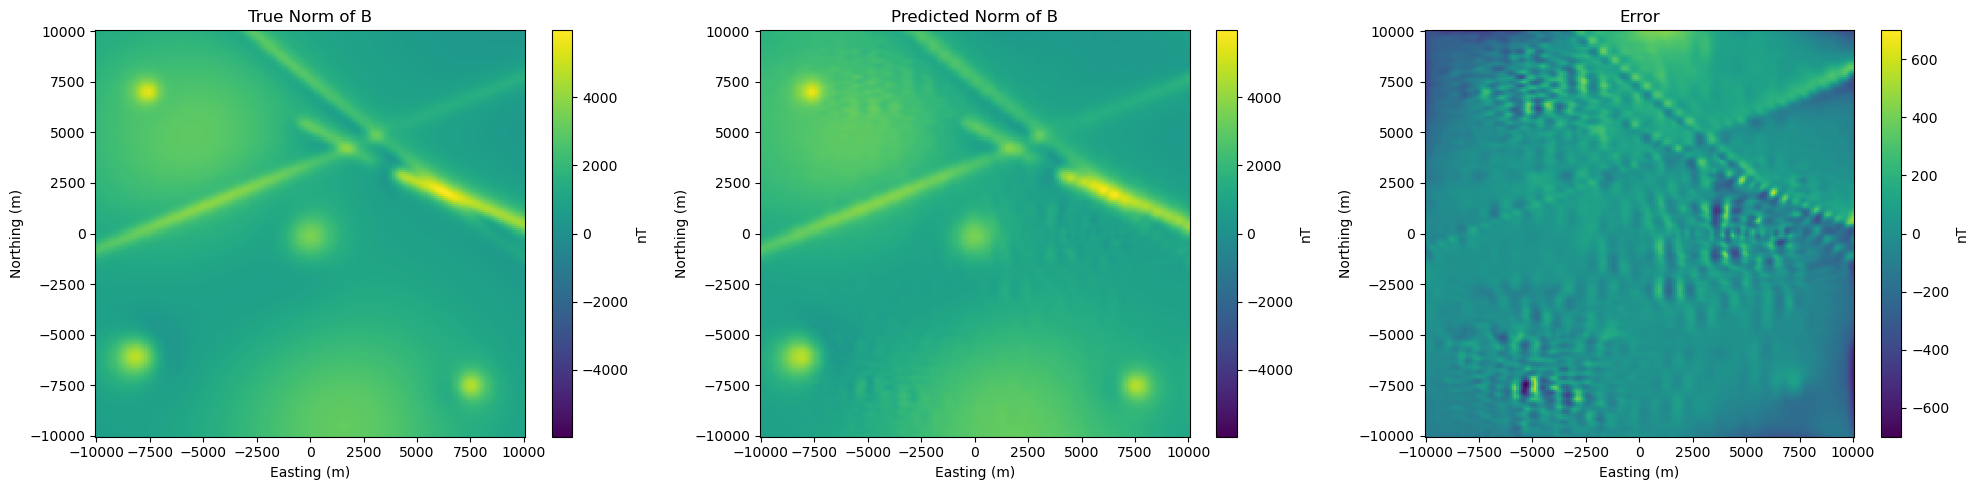

In [21]:
scale_b = vd.maxabs(true_norm_of_b)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.pcolormesh(*grid_coordinates[:2], true_norm_of_b, cmap="viridis", vmin=-scale_b, vmax=scale_b)
plt.title("True Norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
plt.pcolormesh(*grid_coordinates[:2], predicted_norm_of_b, cmap="viridis", vmin=-scale_b, vmax=scale_b)
plt.title("Predicted Norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
diff_scale = vd.maxabs(error_norm_of_b)
plt.pcolormesh(*grid_coordinates[:2], error_norm_of_b, cmap="viridis", vmin=-diff_scale, vmax=diff_scale)
plt.title("Error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()

## Save data

Save data to pandas dataframe

In [26]:
simple_synthetic_data = pd.DataFrame(np.transpose(b_field), columns= ['b_easting','b_northing','b_upward'])

In [27]:
simple_synthetic_data.insert(0, 'easting', np.transpose(coordinates[0]))
simple_synthetic_data.insert(1, 'northing', np.transpose(coordinates[1]))
simple_synthetic_data.insert(2, 'upward', np.transpose(coordinates[2]))
simple_synthetic_data.insert(3, 'observed_tfa', np.transpose(tfa))
simple_synthetic_data.insert(7, 'bnorm', np.transpose(bnorm))
simple_synthetic_data.insert(8, 'tfa_deep', np.transpose(tfa_deep))
simple_synthetic_data.insert(9, 'tfa_deep_residuals', np.transpose(tfa_residuals))
simple_synthetic_data.insert(10, 'tfa_shallow', np.transpose(tfa_residuals_prediction))
simple_synthetic_data.insert(11, 'tfa_shallow_residuals', np.transpose(tfa_residuals - tfa_residuals_prediction))

In [28]:
simple_synthetic_data

,easting,northing,upward,observed_tfa,b_easting,b_northing,b_upward,bnorm,tfa_deep,tfa_deep_residuals,tfa_shallow,tfa_shallow_residuals
0,-9991.179738,-9991.878273,497.916211,165.938995,581.018137,321.744338,-105.902893,672.545105,28.382765,137.556230,111.352101,26.204129
1,-9497.999214,-10003.058782,515.362112,166.813773,609.028788,339.806054,-137.105863,710.761730,53.509408,113.304366,129.422952,-16.118587
2,-8995.106310,-10002.640859,520.220719,244.257759,638.364108,355.513700,-173.617611,751.027163,82.813303,161.444456,128.366427,33.078029
3,-8488.795534,-10005.364843,553.600404,336.188354,665.936217,365.830461,-220.078912,791.035839,123.900373,212.287982,136.709894,75.578087
4,-7990.662210,-9995.672962,549.811347,301.173350,699.008535,370.301907,-270.438794,835.986588,173.724181,127.449169,155.472888,-28.023719
...,...,...,...,...,...,...,...,...,...,...,...,...
92041,9952.272489,9998.096519,505.866834,-364.020281,-139.855133,-124.455901,300.389035,353.952400,65.860431,-429.880712,-363.386831,-66.493881
92042,9968.972431,9999.581168,499.746681,-293.154490,-139.342886,-123.946148,301.035757,354.120904,67.790437,-360.944927,-367.264433,6.319506
92043,9973.979662,10007.906069,494.654253,-268.246877,-139.249783,-123.131791,300.908696,353.691933,72.645921,-340.892797,-374.371357,33.478560
92044,9990.700957,9995.269205,503.074063,-126.029771,-138.510811,-124.485208,301.366911,354.265193,66.297591,-192.327362,-357.032094,164.704733


In [29]:
simple_synthetic_sources = pd.DataFrame(np.transpose(source_coordinates), columns= ['easting','northing','upward'])
simple_synthetic_sources.insert(3, 'dipole_moments_easting', np.transpose(dipole_moments[0]))
simple_synthetic_sources.insert(4, 'dipole_moments_northing', np.transpose(dipole_moments[1]))
simple_synthetic_sources.insert(5, 'dipole_moments_upward', np.transpose(dipole_moments[2]))

In [30]:
simple_synthetic_sources

,easting,northing,upward,dipole_moments_easting,dipole_moments_northing,dipole_moments_upward
0,-20000.00000,-5000.000000,0.0,2.961981e+07,1.710101e+07,-9.396926e+07
1,-19959.95996,-4982.982983,0.0,2.961981e+07,1.710101e+07,-9.396926e+07
2,-19919.91992,-4965.965966,0.0,2.961981e+07,1.710101e+07,-9.396926e+07
3,-19879.87988,-4948.948949,0.0,2.961981e+07,1.710101e+07,-9.396926e+07
4,-19839.83984,-4931.931932,0.0,2.961981e+07,1.710101e+07,-9.396926e+07
...,...,...,...,...,...,...
3101,0.00000,-100.000000,-1000.0,1.480991e+10,8.550504e+09,-4.698463e+10
3102,-8000.00000,-6000.000000,-800.0,1.480991e+10,8.550504e+09,-4.698463e+10
3103,7500.00000,-7500.000000,-500.0,5.923963e+09,3.420201e+09,-1.879385e+10
3104,2000.00000,-9000.000000,-8000.0,2.961981e+12,1.710101e+12,-9.396926e+12


Save grid to xarray

In [31]:
simple_synthetic_grid = vd.make_xarray_grid(grid_coordinates, data=(true_norm_of_b, predicted_norm_of_b), data_names=('true_bnorm', 'predicted_bnorm'), dims=('northing', 'easting'), extra_coords_names='upward')
simple_synthetic_grid

<xarray.Dataset>
Dimensions:          (northing: 201, easting: 201)
Coordinates:
  * easting          (easting) float64 -1e+04 -9.9e+03 ... 9.9e+03 1e+04
  * northing         (northing) float64 -1e+04 -9.9e+03 ... 9.9e+03 1e+04
    upward           (northing, easting) float64 500.0 500.0 ... 500.0 500.0
Data variables:
    true_bnorm       (northing, easting) float64 671.4 679.4 ... 354.2 354.0
    predicted_bnorm  (northing, easting) float64 803.0 800.6 ... 746.1 742.4

- Save pd df to csv
- Save xarray to netCDF

In [32]:
simple_synthetic_data.to_csv('simple_synthetic_data.csv', index=False)
simple_synthetic_sources.to_csv('simple_synthetic_sources.csv', index=False)
simple_synthetic_grid.to_netcdf('simple_synthetic_grid.nc')